In [1]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

from bbutils import BetaBernoulli

In [2]:
predictions = np.genfromtxt("data/svhn/svhn_predictions.txt", delimiter=' ', dtype = float)
df = pd.DataFrame(predictions[:,0].astype(int), columns=['Correct'])
df['Predicted'] = np.argmax(predictions[:,1:11], axis=1)
df['Confidence'] = np.max(predictions[:,1:11], axis=1)
df = df.reset_index()
num_classes = 10

In [3]:
# get value for the varaibles robby defined
category2idx = {i:i for i in range(num_classes)}
idx2category = {i:i for i in range(num_classes)}
categories = df['Predicted'].tolist()
observations = [df['Predicted'][idx] == df['Correct'][idx] for idx in range(df.shape[0])] 

In [4]:
# Try to identify worst class
n = 5001
k = num_classes
runs = 10000
# pseudo_count = 2
mode = 'min'

active_choices = np.zeros((runs, k, n))
active_thetas = np.zeros((runs, k, n))
random_thetas = np.zeros((runs, k, n))

for r in range(runs):

    # Queue choices for each category
    deques = [deque() for _ in range(k)]
    for category, observation in zip(categories, observations):
        deques[category].append(observation)
    ### THIS IS IMPORTANT ###
    for _deque in deques:
        random.shuffle(_deque)
   ####

    # Random model
    model = BetaBernoulli(k)

#     # Prior
#     # model._params = np.vstack((alpha, beta)).T

    n_success = 0
    total = 0
    for i in range(n):
        while True:
            category = random.randrange(k)
            if len(deques[category]) != 0:
                break
        observation = deques[category].pop()
        model.update(category, observation)
        random_thetas[r, :, i] = model._params[:,0] / (model._params[:,0] + model._params[:,1])
    
    # Queue choices for each category
    deques = [deque() for _ in range(k)]
    for category, observation in zip(categories, observations):
        deques[category].append(observation)
    ### THIS IS IMPORTANT ###
    for _deque in deques:
        random.shuffle(_deque)
   ####

    # Beta Bernoulli model
    model = BetaBernoulli(k)

    # Prior
    # model._params = np.vstack((alpha, beta)).T

    n_success = 0
    total = 0

    for i in range(n):
        theta_hat = model.sample()
        
        if mode == 'max':
            choices = np.argsort(theta_hat)[::-1]
        elif mode == 'min':
            choices = np.argsort(theta_hat)
            
        for j in range(k):
            category = choices[j]
            if len(deques[category]) != 0:
                break
        observation = deques[category].pop()
        model.update(category, observation)
        #beta_bernoulli_outcome[i] = n_success / (total + 1e-13)
        active_thetas[r, :, i] = model._params[:,0] / (model._params[:,0] + model._params[:,1])
        if i > 0:
            active_choices[r, :, i] = active_choices[r, :, i - 1]
        active_choices[r, category, i] += 1

In [5]:
correct = np.zeros(k)
total = np.zeros(k)

for category, observation in zip(categories, observations):
    if observation:
        correct[category] += 1
    total[category] += 1
    
empirical_acc = correct / total
ranked = np.argsort(empirical_acc)[::-1]
print(empirical_acc)

[0.96420455 0.9661705  0.97816594 0.95717796 0.97429814 0.96827411
 0.96403242 0.9726997  0.96875    0.95182211]


9
3
6
0
1
5
8
7
4
2


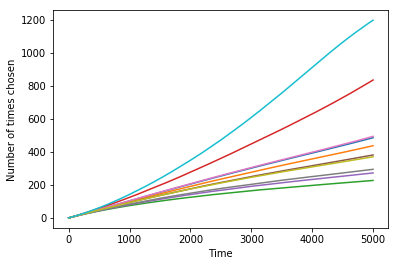

In [6]:
avg_active_choices = np.mean(active_choices, axis=0)

for i in range(k):
    plt.plot(avg_active_choices[i,:])
    plt.xlabel('Time')
    plt.ylabel('Number of times chosen')

top = np.argsort(avg_active_choices[:,-1])[::-1]

for i in top[:10]:
    print(idx2category[i])

In [7]:
most_chosen = np.argmax(active_choices[:, :, :], axis=1)

cutoff = 9

if mode == 'max':
    selection = ranked[:cutoff]
elif mode == 'min':
    selection = ranked[-cutoff:]
    selection = selection[::-1]
    
timestamps = [100, 200, 300, 400, 500]

table = np.zeros((cutoff+1, len(timestamps)))
    
for i, category in enumerate(selection):
    for j, timestamp in enumerate(timestamps):
        table[i,j] = np.mean(most_chosen[:,timestamp] == category)

table[cutoff,:] = 1 - np.sum(table, axis=0)

In [8]:
header = ' ' * 10 + ' '.join('%6i' % x for x in timestamps)
print(header)

for i, row in enumerate(table):
    if i < cutoff:
        category = idx2category[selection[i]]
    else:
        category = 'OTHER'
    category_string = '{}'.format(category) + ' ' * 10
    num_string = ' '.join('{:.04f}'.format(x) for x in row.tolist())
    print(category_string + num_string)

             100    200    300    400    500
9          0.1357 0.1689 0.1919 0.2077 0.2258
3          0.1437 0.1597 0.1702 0.1794 0.1873
6          0.1020 0.1072 0.1047 0.1107 0.1121
0          0.1240 0.1147 0.1124 0.1076 0.1060
1          0.1102 0.1025 0.1012 0.0981 0.0956
5          0.0944 0.0869 0.0808 0.0781 0.0743
8          0.0851 0.0842 0.0823 0.0797 0.0753
7          0.0666 0.0670 0.0583 0.0531 0.0507
4          0.0717 0.0607 0.0546 0.0496 0.0431
OTHER          0.0666 0.0482 0.0436 0.0360 0.0298


In [9]:
random_success = np.mean(np.argmin(random_thetas, axis=1) == selection[0], axis=0)
active_success = np.mean(np.argmin(active_thetas, axis=1) == selection[0], axis=0)

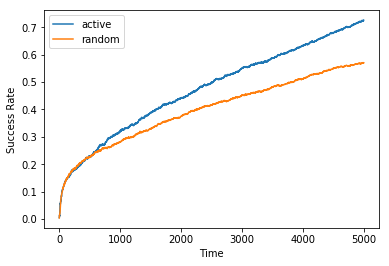

In [10]:
plt.plot(active_success, label='active')
plt.plot(random_success, label='random')
plt.xlabel('Time')
plt.ylabel('Success Rate')
plt.legend()